In [1]:
import pandas as pd
import spacy
from collections import defaultdict
import plotly.graph_objects as go
import plotly.io as pio

In [2]:
# Charger le modèle spaCy pour le français
nlp = spacy.load("pl_core_news_sm")

# Chargement du fichier existant
df = pd.read_csv("erreurs_prononciation.csv")

# Nettoyage et conversion des apprenants en ensembles de nombres
def parse_apprenants(apprenant_str):
    return set(map(str.strip, str(apprenant_str).split(','))) if pd.notna(apprenant_str) else set()

# Fonction pour détecter pays à partir du numéro d'apprenant
def detect_country_counts(apprenants_set):
    counts = {'FR': 0, 'IT': 0, 'NL': 0, 'UK': 0, 'GE': 0}
    for a in apprenants_set:
        if a.startswith('1'):
            counts['FR'] += 1
        elif a.startswith('5'):
            counts['IT'] += 1
        elif a.startswith('2'):
            counts['NL'] += 1
        elif a.startswith('3'):
            counts['UK'] += 1
        elif a.startswith('4'):
            counts['GE'] += 1
    return counts

# Trouver le lemme de la forme correcte (on ne garde que le premier mot lemmatisé)
def get_lemma(text):
    doc = nlp(str(text))
    for token in doc:
        if token.is_alpha:
            return token.lemma_.lower()
    return str(text).lower()

# Ajouter la colonne "Lemme"
df["Lemme"] = df["Forme correcte"].apply(get_lemma)

# Grouper les lignes selon le lemme + Correcte + Erroné
group_dict = defaultdict(list)
for idx, row in df.iterrows():
    key = (row["Lemme"], row["Correcte"], row["Erroné"])
    group_dict[key].append(row)

# Fusionner les groupes
rows = []
for (lemme, corr, err), group_rows in group_dict.items():
    formes_correctes = sorted(set(r["Forme correcte"] for r in group_rows if pd.notna(r["Forme correcte"])))
    formes_erronees = sorted(set()
        .union(*[set(str(r["Forme erronée (manuel)"]).split(',')) for r in group_rows if pd.notna(r["Forme erronée (manuel)"])]))
    
    all_apprenants = set()
    for r in group_rows:
        all_apprenants.update(parse_apprenants(r["Apprenants"]))
    all_apprenants_list = sorted(all_apprenants, key=lambda x: int(x))
    all_apprenants_str = ", ".join(all_apprenants_list)

    country_counts = detect_country_counts(all_apprenants)

    row = {
        "Forme(s) correcte(s)": ", ".join(formes_correctes),
        "Forme(s) erronée(s)": ", ".join(formes_erronees),
        "Correcte": corr,
        "Erroné": err,
        "FR": country_counts["FR"],
        "IT": country_counts["IT"],
        "NL": country_counts["NL"],
        "UK": country_counts["UK"],
        "GE": country_counts["GE"],
        "Nombre total d'apprenants": len(all_apprenants),
        "Apprenants": all_apprenants_str
    }
    rows.append(row)

# Création du DataFrame final
final_df = pd.DataFrame(rows)

# Tri décroissant par Nombre total d'apprenants
final_df_sorted = final_df.sort_values(by="Nombre total d'apprenants", ascending=False)

# Sauvegarde dans un nouveau fichier
final_df_sorted.to_csv("erreurs_prononciation_groupées_par_mots.csv", index=False, encoding="utf-8")

print("Fichier généré : erreurs_prononciation_groupées_par_mots.csv")

Fichier généré : erreurs_prononciation_groupées_par_mots.csv


In [3]:
import pandas as pd
import epitran

# Initialisation de l'outil Epitran pour le polonais
epi = epitran.Epitran('pol-Latn')

# Chargement du fichier CSV contenant les données groupées par mot
df = pd.read_csv("erreurs_prononciation_groupées_par_mots.csv")

# Fonction pour convertir une chaîne (ou une liste séparée par des virgules) en alphabet phonétique
def convert_to_ipa(text):
    if pd.isna(text) or not isinstance(text, str):
        return ""
    mots = [mot.strip() for mot in text.split(",")]
    mots_ipa = [epi.transliterate(mot) for mot in mots]
    return ", ".join(mots_ipa)

# Application de la conversion sur les colonnes concernées
df["Forme(s) correcte(s)"] = df["Forme(s) correcte(s)"].apply(convert_to_ipa)
df["Forme(s) erronée(s)"] = df["Forme(s) erronée(s)"].apply(convert_to_ipa)
df["Correcte"] = df["Correcte"].apply(convert_to_ipa)
df["Erroné"] = df["Erroné"].apply(convert_to_ipa)

# Sauvegarde du nouveau fichier avec les formes en API
df.to_csv("erreurs_prononciation_groupées_par_mots_API.csv", index=False, encoding="utf-8")

print("Fichier généré : erreurs_prononciation_groupées_par_mots_API.csv")

Fichier généré : erreurs_prononciation_groupées_par_mots_API.csv


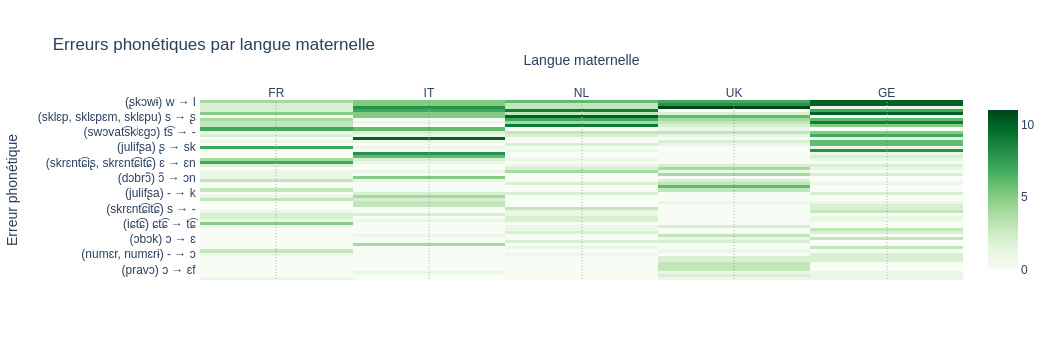

In [4]:
# Tri et sélection des 59 erreurs les plus fréquentes
top_errors = pd.read_csv("erreurs_prononciation_groupées_par_mots_API.csv").head(59)

# Création de la colonne "Erreur"
top_errors["Erreur"] = "(" + top_errors["Forme(s) correcte(s)"] + ") " + top_errors["Correcte"] + " → " + top_errors["Erroné"] + " "

# Calcul du total des erreurs par ligne
top_errors["Total par erreur"] = top_errors[["FR", "IT", "NL", "UK", "GE"]].sum(axis=1)

# Transformation des données au format long
heatmap_data = top_errors.melt(
    id_vars=["Erreur", "Total par erreur", "Forme(s) erronée(s)"],
    value_vars=["FR", "IT", "NL", "UK", "GE"],
    var_name="Langue",
    value_name="Nombre d'erreurs"
)

# Définir l'ordre des erreurs selon le total
heatmap_data["Erreur"] = pd.Categorical(
    heatmap_data["Erreur"],
    categories=heatmap_data.groupby("Erreur")["Total par erreur"].mean().sort_values(ascending=False).index,
    ordered=True
)

# Création de la heatmap avec le nombre d'erreurs affiché sur les cases
# et les mots affichés dans le tooltip
fig = go.Figure(data=go.Heatmap(
    x=heatmap_data["Langue"],
    y=heatmap_data["Erreur"],
    z=heatmap_data["Nombre d'erreurs"],
    text=heatmap_data["Nombre d'erreurs"],  # valeurs visibles sur les cases
    customdata=heatmap_data[["Forme(s) erronée(s)"]].values,  # mots visibles dans le tooltip
    colorscale="Greens",
    hovertemplate="%{customdata[0]}<extra></extra>",  # seulement les mots dans le tooltip
    texttemplate="%{text}",  # affichage du nombre d’erreurs sur les cases
    showscale=True
))

# Mise en forme du graphique
fig.update_layout(
    title="Erreurs phonétiques par langue maternelle",
    xaxis=dict(title="Langue maternelle", side="top"),
    yaxis_title="Erreur phonétique",
    yaxis=dict(autorange="reversed"),
    height=2000
)

fig.show()
